# Halo Setup + YOLO Inference

Workflow:
1) Setup: sample frames, template-match, and fit halo ellipse (CSV generated)
2) Inference: run YOLO on a video and signal when the ball stays inside the halo

In [3]:
import os
import sys
import cv2
import csv
import glob
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO

sys.path.append(str(Path.cwd().parent))
from utils.file_dialog_utils import pick_video_cv2, pick_folder, pick_file


CSV saved: zero_points.csv
Halo center: (488.41845703125, 394.48809814453125) | angle_deg: 91.17


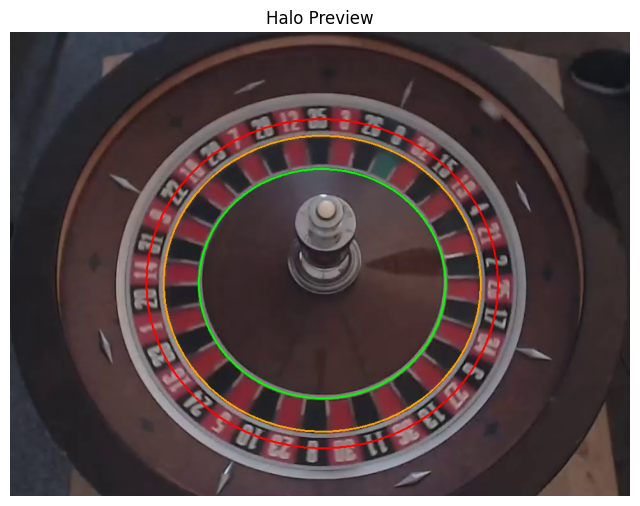

In [4]:
# ---- Setup: template matching + halo fit ----

def load_templates_with_names(folder_path):
    paths = sorted(glob.glob(os.path.join(folder_path, "*.png")))
    template_data = []
    for p in paths:
        img = cv2.imread(p)
        if img is not None:
            template_data.append((os.path.basename(p), img))
    return template_data


def preprocess_templates_for_video(template_data):
    processed = []
    for name, img_bgr in template_data:
        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        h, w = gray.shape
        processed.append((name, gray, w, h))
    return processed


def find_best_match_fast(target_gray, gray_templates):
    best_match = {"score": -1.0, "location": None, "width": 0, "height": 0, "name": ""}
    for name, tmpl_gray, w, h in gray_templates:
        res = cv2.matchTemplate(target_gray, tmpl_gray, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, max_loc = cv2.minMaxLoc(res)
        if max_val > best_match["score"]:
            best_match.update({"score": max_val, "location": max_loc, "width": w, "height": h, "name": name})
    return best_match


def distributed_frame_indices(total_frames, n):
    n = int(max(1, n))
    if total_frames <= 0:
        return [0]
    idx = np.linspace(0, max(0, total_frames - 1), n, dtype=int)
    return np.unique(idx).tolist()


def fit_circle_least_squares(points_xy):
    x = points_xy[:, 0]
    y = points_xy[:, 1]
    A = np.c_[2 * x, 2 * y, np.ones_like(x)]
    b = x ** 2 + y ** 2
    sol, *_ = np.linalg.lstsq(A, b, rcond=None)
    cx, cy, c = sol
    r = math.sqrt(max(0.0, c + cx ** 2 + cy ** 2))
    return float(cx), float(cy), float(r)


def process_video_sampled_frames(video_path, template_folder, n_samples=30, min_score=0.60, csv_path="zero_points.csv"):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Could not open video: {video_path}")

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    ok, first_frame = cap.read()
    if not ok:
        cap.release()
        raise RuntimeError("Could not read first frame.")

    templates_with_names = load_templates_with_names(template_folder)
    gray_templates = preprocess_templates_for_video(templates_with_names)

    sample_idxs = distributed_frame_indices(total_frames, n_samples)
    rows = []

    for idx in sample_idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
        ok, frame = cap.read()
        if not ok:
            continue

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        match = find_best_match_fast(gray, gray_templates)
        if match.get("location") is None:
            continue
        score = float(match["score"])
        if score < min_score:
            continue

        tlx, tly = match["location"]
        w, h = match["width"], match["height"]
        cx = tlx + w / 2.0
        cy = tly + h / 2.0

        rows.append({"frame_idx": int(idx), "center_x": float(cx), "center_y": float(cy), "score": score, "template": match.get("name", "")})

    cap.release()

    if not rows:
        raise RuntimeError("No points accepted. Try lowering min_score or increasing n_samples.")

    with open(csv_path, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=["frame_idx", "center_x", "center_y", "score", "template"])
        writer.writeheader()
        writer.writerows(rows)

    points_xy = np.array([(r["center_x"], r["center_y"]) for r in rows], dtype=np.float32)
    if len(points_xy) >= 5:
        (cx, cy), (MA, ma), angle = cv2.fitEllipse(points_xy.reshape(-1, 1, 2))
        rx, ry = MA / 2.0, ma / 2.0
    else:
        cx, cy, r = fit_circle_least_squares(points_xy.astype(np.float64))
        rx, ry, angle = r, r, 0.0

    return {
        "center": (float(cx), float(cy)),
        "axes": (float(rx), float(ry)),
        "angle_deg": float(angle),
        "csv_path": csv_path,
        "first_frame": first_frame
    }


def build_halo_params(ellipse_params, outer_inward_pct, inner_inward_pct):
    if inner_inward_pct <= outer_inward_pct:
        raise ValueError("inner_inward_pct must be greater than outer_inward_pct")
    cx, cy = ellipse_params["center"]
    rx, ry = ellipse_params["axes"]
    angle_deg = ellipse_params["angle_deg"]

    outer_rx = rx * (1.0 - outer_inward_pct)
    outer_ry = ry * (1.0 - outer_inward_pct)
    inner_rx = rx * (1.0 - inner_inward_pct)
    inner_ry = ry * (1.0 - inner_inward_pct)

    return {
        "center": (cx, cy),
        "base_axes": (rx, ry),
        "outer_axes": (outer_rx, outer_ry),
        "inner_axes": (inner_rx, inner_ry),
        "angle_deg": angle_deg
    }


def preview_halo(frame_bgr, halo_params):
    overlay = frame_bgr.copy()
    cx, cy = halo_params["center"]
    base_rx, base_ry = halo_params["base_axes"]
    outer_rx, outer_ry = halo_params["outer_axes"]
    inner_rx, inner_ry = halo_params["inner_axes"]
    angle_deg = halo_params["angle_deg"]

    cv2.ellipse(overlay, (int(cx), int(cy)), (int(outer_rx), int(outer_ry)), angle_deg, 0, 360, (0, 165, 255), 2)
    cv2.ellipse(overlay, (int(cx), int(cy)), (int(inner_rx), int(inner_ry)), angle_deg, 0, 360, (0, 255, 0), 2)
    cv2.ellipse(overlay, (int(cx), int(cy)), (int(base_rx), int(base_ry)), angle_deg, 0, 360, (0, 0, 255), 2)

    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Halo Preview")
    plt.show()


# Settings
N_SAMPLES = 30
MIN_SCORE = 0.60
OUTER_INWARD_PCT = 0.10
INNER_INWARD_PCT = 0.30
CSV_PATH = "zero_points.csv"

_, setup_video_path = pick_video_cv2(title="Select Input Video (Setup)")
templates_dir = pick_folder(title="Select Template Folder")

ellipse_params = process_video_sampled_frames(
    video_path=setup_video_path,
    template_folder=templates_dir,
    n_samples=N_SAMPLES,
    min_score=MIN_SCORE,
    csv_path=CSV_PATH
)

halo_params = build_halo_params(ellipse_params, OUTER_INWARD_PCT, INNER_INWARD_PCT)
print(f"CSV saved: {ellipse_params['csv_path']}")
print(f"Halo center: {halo_params['center']} | angle_deg: {halo_params['angle_deg']:.2f}")

# Uncomment to preview halo overlay on the first frame
preview_halo(ellipse_params['first_frame'], halo_params)


In [5]:
# ---- YOLO model setup ----

def resolve_ball_class(model, class_value):
    if isinstance(class_value, int):
        return class_value
    text = str(class_value).strip()
    if text.isdigit():
        return int(text)
    if text.startswith("[") and "]" in text:
        inner = text[1:text.index("]")].strip()
        if inner.isdigit():
            return int(inner)
    for k, v in model.names.items():
        if v == text:
            return k
    raise ValueError(f"Could not resolve class: {class_value}")

MODEL_PATH = pick_file("Select a YOLO model file", [("YOLO model files", "*.pt")])
model = YOLO(MODEL_PATH)
print("Loaded model:", MODEL_PATH)
print("Classes:", model.names)

BALL_CLASS = 0  
BALL_CLASS_ID = resolve_ball_class(model, BALL_CLASS)

CONF_THRES = 0.40
IOU_THRES = 0.70
DEVICE = 0

DISPLAY_SCALE = 0.60
WINDOW_NAME = "YOLO Halo Inference (Press Q to Quit)"
LANDING_SECONDS = 3.0


Loaded model: C:/Users/Gabriel/Documents/Dissertation/Code/models/yolo/RD2_Model.pt
Classes: {0: 'ball'}


In [6]:
# ---- Inference: signal if ball stays in halo ----

def point_in_ellipse(px, py, cx, cy, rx, ry, angle_deg):
    if rx <= 0 or ry <= 0:
        return False
    angle = np.deg2rad(angle_deg)
    cos_a = np.cos(angle)
    sin_a = np.sin(angle)
    dx = px - cx
    dy = py - cy
    x = cos_a * dx + sin_a * dy
    y = -sin_a * dx + cos_a * dy
    return (x * x) / (rx * rx) + (y * y) / (ry * ry) <= 1.0


def point_in_halo(px, py, halo_params):
    cx, cy = halo_params["center"]
    outer_rx, outer_ry = halo_params["outer_axes"]
    inner_rx, inner_ry = halo_params["inner_axes"]
    angle_deg = halo_params["angle_deg"]
    inside_outer = point_in_ellipse(px, py, cx, cy, outer_rx, outer_ry, angle_deg)
    inside_inner = point_in_ellipse(px, py, cx, cy, inner_rx, inner_ry, angle_deg)
    return inside_outer and not inside_inner


if "halo_params" not in globals():
    raise RuntimeError("Run the setup cell first to compute halo_params.")

_, inference_video_path = pick_video_cv2(title="Select Input Video (Inference)")
cap = cv2.VideoCapture(inference_video_path)
if not cap.isOpened():
    raise RuntimeError(f"Could not open video: {inference_video_path}")

fps = cap.get(cv2.CAP_PROP_FPS)
if not fps or fps <= 1e-3:
    fps = 30.0
frame_dt = 1.0 / fps

cv2.namedWindow(WINDOW_NAME, cv2.WINDOW_NORMAL)
cv2.resizeWindow(WINDOW_NAME, 1280, 720)

time_in_halo = 0.0
landed = False

try:
    while True:
        ok, frame = cap.read()
        if not ok:
            break

        results = model.predict(
            source=frame,
            conf=CONF_THRES,
            iou=IOU_THRES,
            device=DEVICE,
            verbose=False
        )
        r = results[0]
        display = r.plot()

        best_det = None
        if r.boxes is not None and len(r.boxes) > 0:
            for box in r.boxes:
                cls_id = int(box.cls[0].item())
                if cls_id != BALL_CLASS_ID:
                    continue
                conf = float(box.conf[0].item())
                if best_det is None or conf > best_det["conf"]:
                    xyxy = box.xyxy[0].tolist()
                    best_det = {"xyxy": xyxy, "conf": conf}

        in_halo = False
        if best_det is not None:
            x1, y1, x2, y2 = best_det["xyxy"]
            cx = (x1 + x2) / 2.0
            cy = (y1 + y2) / 2.0
            in_halo = point_in_halo(cx, cy, halo_params)

        if in_halo:
            time_in_halo += frame_dt
        else:
            time_in_halo = 0.0
            landed = False

        if time_in_halo >= LANDING_SECONDS:
            landed = True

        # Draw halo boundaries on display
        cx, cy = halo_params["center"]
        outer_rx, outer_ry = halo_params["outer_axes"]
        inner_rx, inner_ry = halo_params["inner_axes"]
        angle_deg = halo_params["angle_deg"]
        cv2.ellipse(display, (int(cx), int(cy)), (int(outer_rx), int(outer_ry)), angle_deg, 0, 360, (0, 165, 255), 2)
        cv2.ellipse(display, (int(cx), int(cy)), (int(inner_rx), int(inner_ry)), angle_deg, 0, 360, (0, 255, 0), 2)

        status = f"In halo: {in_halo} | time: {time_in_halo:.2f}s"
        cv2.putText(display, status, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        if landed:
            cv2.putText(display, "BALL LANDED", (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0, 0, 255), 3)

        if DISPLAY_SCALE != 1.0:
            h, w = display.shape[:2]
            display = cv2.resize(display, (int(w * DISPLAY_SCALE), int(h * DISPLAY_SCALE)), interpolation=cv2.INTER_AREA)

        cv2.imshow(WINDOW_NAME, display)
        key = cv2.waitKey(1) & 0xFF
        if key in (ord('q'), ord('Q')):
            break
finally:
    cap.release()
    cv2.destroyAllWindows()
